# Project 4: 
# West Nile Virus Prediction

Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

Submissions are evaluated on area under the ROC curve between the predicted probability that West Nile Virus is present and the observed outcomes. (For each record in the test set, you should predict a real-valued probability that WNV is present)

- The training set consists of data from 2007, 2009, 2011, and 2013
- The test set you are requested to predict the test results for 2008, 2010, 2012, and 2014.

## Step 1: Load the data and perform basic operations.

In [772]:
# Import some necessary librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

In [701]:
# load all datasets in pandas dataframes
train_data = pd.read_csv('../assets/train.csv')
test_data = pd.read_csv('../assets/test.csv')
spray_data = pd.read_csv('../assets/spray.csv')
weather_data = pd.read_csv('../assets/weather.csv')

In [702]:
# display the first five rows of the train dataset.
train_data.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [703]:
# Id: the id of the record
# Date: date that the WNV test is performed
# Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
# Species: the species of mosquitos
# Block: block number of address
# Street: street name
# Trap: Id of the trap
# AddressNumberAndStreet: approximate address returned from GeoCoder
# Latitude, Longitude: Latitude and Longitude returned from GeoCoder
# AddressAccuracy: accuracy returned from GeoCoder
# NumMosquitos: number of mosquitoes caught in this trap
# WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. 

In [704]:
# display the first five rows of the test dataset.
test_data.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [705]:
# display the first five rows of the spray dataset.
spray_data.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [706]:
# display the first five rows of the weather dataset.
weather_data.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


#### 1- Understand Problem and features:

In [707]:
# Number of observations in trainset
print('Observations Number in the Trainset: {}'.format(len(train_data)))

Observations Number in the Trainset: 10506


In [708]:
# Number of observations in testset
print('Observations Number in the Testset: {}'.format(len(test_data)))

Observations Number in the Testset: 116293


In [709]:
# number of features for each train and test set
print('Features Number in trainset: {}'.format(len(train_data.columns)))
print('Features Number in testset: {}'.format(len(test_data.columns)))


Features Number in trainset: 12
Features Number in testset: 11


In [710]:
# Train Features names:
train_data.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [711]:
# Test Features names:
test_data.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

#### 2- Merge Datasets:

In [712]:
# Merge train and test data to perform preprocess together
both = pd.concat([train_data,test_data], axis=0, sort=True, ignore_index=True)
both.head(2)

,Address,AddressAccuracy,AddressNumberAndStreet,Block,Date,Id,Latitude,Longitude,NumMosquitos,Species,Street,Trap,WnvPresent
0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9,"4100 N OAK PARK AVE, Chicago, IL",41,2007-05-29,NaN,41.95469,-87.800991,1.0,CULEX PIPIENS/RESTUANS,N OAK PARK AVE,T002,0.0
1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9,"4100 N OAK PARK AVE, Chicago, IL",41,2007-05-29,NaN,41.95469,-87.800991,1.0,CULEX RESTUANS,N OAK PARK AVE,T002,0.0


In [713]:
# check shape
both.shape

(126799, 13)

In [714]:
# store train data index
train_index = both[:train_data.shape[0]].index.values
train_index

array([    0,     1,     2, ..., 10503, 10504, 10505])

In [715]:
# store test data index
test_index = both[train_data.shape[0]:].index.values
test_index

array([ 10506,  10507,  10508, ..., 126796, 126797, 126798])

In [716]:
# Merge weather data to previous dataframe
weather_data.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [717]:
# Station 1: CHICAGO O’HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
station_lat_1 = 41.995 
station_lat_2 = 41.786

In [718]:
# add station column to previous integrated dataframe to help us during merge

# set defult value as station = 1
both['Station'] = 1
both.loc[round(both.Latitude, 1) <= round(station_lat_2, 1),'Station'] = 2

In [719]:
# check station colimn
both.Station.value_counts()

1    65046
2    61753
Name: Station, dtype: int64

In [720]:
# check size before merge
both.shape

(126799, 14)

In [721]:
# Merging now (weather data to previous dataframe)
both = pd.merge(both,weather_data,on=['Date','Station'],how='inner')

In [722]:
# check size after merge
both.shape

(126799, 34)

In [723]:
both.head(2)

,Address,AddressAccuracy,AddressNumberAndStreet,Block,Date,Id,Latitude,Longitude,NumMosquitos,Species,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9,"4100 N OAK PARK AVE, Chicago, IL",41,2007-05-29,NaN,41.95469,-87.800991,1.0,CULEX PIPIENS/RESTUANS,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9,"4100 N OAK PARK AVE, Chicago, IL",41,2007-05-29,NaN,41.95469,-87.800991,1.0,CULEX RESTUANS,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5


In [724]:
both.columns

Index(['Address', 'AddressAccuracy', 'AddressNumberAndStreet', 'Block', 'Date',
       'Id', 'Latitude', 'Longitude', 'NumMosquitos', 'Species', 'Street',
       'Trap', 'WnvPresent', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum',
       'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [725]:
both[['Address', 'AddressNumberAndStreet', 'Block', 'Latitude', 'Longitude', 'Street', 'AddressAccuracy', 'Station']].head()

,Address,AddressNumberAndStreet,Block,Latitude,Longitude,Street,AddressAccuracy,Station
0,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 N OAK PARK AVE, Chicago, IL",41,41.954690,-87.800991,N OAK PARK AVE,9,1
1,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 N OAK PARK AVE, Chicago, IL",41,41.954690,-87.800991,N OAK PARK AVE,9,1
2,"6200 North Mandell Avenue, Chicago, IL 60646, USA","6200 N MANDELL AVE, Chicago, IL",62,41.994991,-87.769279,N MANDELL AVE,9,1
3,"7900 West Foster Avenue, Chicago, IL 60656, USA","7900 W FOSTER AVE, Chicago, IL",79,41.974089,-87.824812,W FOSTER AVE,8,1
4,"7900 West Foster Avenue, Chicago, IL 60656, USA","7900 W FOSTER AVE, Chicago, IL",79,41.974089,-87.824812,W FOSTER AVE,8,1


In [726]:
# drop unnecessary columns
both.drop(['Address', 'AddressNumberAndStreet','Latitude', 'Longitude','NumMosquitos','Street'], axis=1, inplace=True)

In [727]:
both.columns

Index(['AddressAccuracy', 'Block', 'Date', 'Id', 'Species', 'Trap',
       'WnvPresent', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [728]:
both.head(2)

,AddressAccuracy,Block,Date,Id,Species,Trap,WnvPresent,Station,Tmax,Tmin,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,9,41,2007-05-29,NaN,CULEX PIPIENS/RESTUANS,T002,0.0,1,88,60,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
1,9,41,2007-05-29,NaN,CULEX RESTUANS,T002,0.0,1,88,60,...,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5


#### 3- Univariable (Target) Study:

In [729]:
# target - WnvPresent 
train_data.WnvPresent.describe()

count    10506.000000
mean         0.052446
std          0.222936
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: WnvPresent, dtype: float64

In [730]:
# our target as zeros and ones
train_data.WnvPresent.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

#### 3- Multivariate Study:

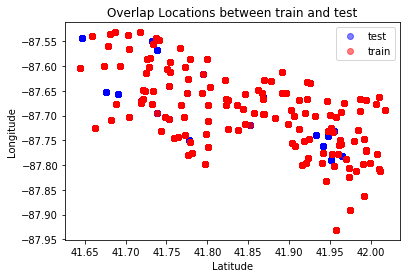

In [731]:
# check overlap locations using Longitude, Latitude for train and test set
plt.plot(test_data['Latitude'],test_data['Longitude'],'bo',label='test',alpha=0.5);
plt.plot(train_data['Latitude'],train_data['Longitude'],'ro',label='train',alpha=0.5);
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Overlap Locations between train and test')
plt.legend();

In [732]:
# plot usefull graphs
def plotGroupedBy(col):
    wnv_present = train_data.groupby([col]).sum()['WnvPresent'] > 0
    present_counts = train_data.groupby([col]).count()['WnvPresent'][wnv_present].get_values()
    npresent_counts = train_data.groupby([col]).count()['WnvPresent'][-wnv_present].get_values()
    plt.hist([present_counts,npresent_counts], 50, stacked=True,label=['present','not present'])
    plt.legend();

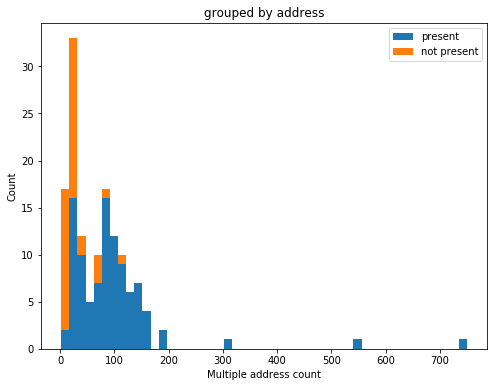

In [733]:
plt.figure(figsize=(8,6));
plotGroupedBy('Address');
plt.title('grouped by address');
plt.xlabel('Multiple address count');
plt.ylabel('Count');

In [734]:
##### Here remaining graphs

## Step 2: Cleaning and Manipulate the dataframe

### 1- Check Missing values:

- Change type of some numerical feaures that are really categorical

In [735]:
# check which columns are missing
both.isnull().sum() 
# missing id : id for trainset
# missing WnvPresent : target for testset

AddressAccuracy         0
Block                   0
Date                    0
Id                  10506
Species                 0
Trap                    0
WnvPresent         116293
Station                 0
Tmax                    0
Tmin                    0
Tavg                    0
Depart                  0
DewPoint                0
WetBulb                 0
Heat                    0
Cool                    0
Sunrise                 0
Sunset                  0
CodeSum                 0
Depth                   0
Water1                  0
SnowFall                0
PrecipTotal             0
StnPressure             0
SeaLevel                0
ResultSpeed             0
ResultDir               0
AvgSpeed                0
dtype: int64

In [736]:
both.dtypes

AddressAccuracy      int64
Block                int64
Date                object
Id                 float64
Species             object
Trap                object
WnvPresent         float64
Station              int64
Tmax                 int64
Tmin                 int64
Tavg                object
Depart              object
DewPoint             int64
WetBulb             object
Heat                object
Cool                object
Sunrise             object
Sunset              object
CodeSum             object
Depth               object
Water1              object
SnowFall            object
PrecipTotal         object
StnPressure         object
SeaLevel            object
ResultSpeed        float64
ResultDir            int64
AvgSpeed            object
dtype: object

In [737]:
both.iloc[:,12:].head()

,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
1,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
2,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
3,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5
4,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.00,29.39,30.11,5.8,18,6.5


##### 1- Tavg

In [738]:
# check null Tavg
len(both[both.Tavg == 'M'])

0

In [739]:
# convert type to int
both['Tavg'] = both['Tavg'].astype('int')

##### 2- Depart, WetBulb, Heat, Cool, Depth, StnPressure, SeaLevel, AvgSpeed

In [740]:
# Cleaning columns with the value 'M' by replacing it with NaN.
both['Depart'] = pd.to_numeric(both['Depart'], errors='coerce', downcast='integer')
both['WetBulb'] = pd.to_numeric(both['WetBulb'], errors='coerce', downcast='integer')
both['Heat'] = pd.to_numeric(both['Heat'], errors='coerce', downcast='integer')
both['Cool'] = pd.to_numeric(both['Cool'], errors='coerce', downcast='integer')
both['Depth'] = pd.to_numeric(both['Depth'], errors='coerce', downcast='integer')
both['StnPressure'] = pd.to_numeric(both['StnPressure'], errors='coerce', downcast='float')
both['SeaLevel'] = pd.to_numeric(both['SeaLevel'], errors='coerce', downcast='float')
both['AvgSpeed'] = pd.to_numeric(both['AvgSpeed'], errors='coerce', downcast='float')

In [741]:
both.isnull().sum() 

AddressAccuracy         0
Block                   0
Date                    0
Id                  10506
Species                 0
Trap                    0
WnvPresent         116293
Station                 0
Tmax                    0
Tmin                    0
Tavg                    0
Depart              61753
DewPoint                0
WetBulb                61
Heat                    0
Cool                    0
Sunrise                 0
Sunset                  0
CodeSum                 0
Depth               61753
Water1                  0
SnowFall                0
PrecipTotal             0
StnPressure            61
SeaLevel                0
ResultSpeed             0
ResultDir               0
AvgSpeed                0
dtype: int64

In [742]:
# fill nulls
#Forward filling
both['Depart'].fillna(method='ffill', inplace=True)
both['WetBulb'].fillna(method='ffill', inplace=True)
both['Depth'].fillna(method='ffill', inplace=True)
both['StnPressure'].fillna(method='ffill', inplace=True)

##### 3- Water1

In [743]:
# check water value
both[both.Water1 != 'M'].shape

(0, 28)

In [744]:
# Dropping column Water1 because the entire column has only value M.
both = both.drop(columns='Water1')

##### 4- Sunset, Sunrise

In [745]:
# replace values '-' with Nan
both['Sunset'] = both['Sunset'].apply(lambda x: np.nan if x == '-' else x)
both['Sunrise'] = both['Sunrise'].apply(lambda x: np.nan if x == '-' else x)

In [746]:
# check null values
both['Sunset'].isnull().sum()

61753

In [747]:
#Forward filling
both['Sunrise'].fillna(method='ffill', inplace=True)
both['Sunset'].fillna(method='ffill', inplace=True)

##### 5- SnowFall, PrecipTotal

In [748]:
both['SnowFall'].value_counts()

0.0    64319
M      61753
  T      727
Name: SnowFall, dtype: int64

In [749]:
both['SnowFall'] = both['SnowFall'].apply(lambda x: np.nan if x == 'M' else x)
both['SnowFall'] = both['SnowFall'].apply(lambda x: 0.005 if x == '  T' else x).astype('float')

In [750]:
both['PrecipTotal'] = both['PrecipTotal'].apply(lambda x: np.nan if x == 'M' else x)
both['PrecipTotal'] = both['PrecipTotal'].apply(lambda x: 0.005 if x == '  T' else x).astype('float')

In [751]:
both.isnull().sum() 

AddressAccuracy         0
Block                   0
Date                    0
Id                  10506
Species                 0
Trap                    0
WnvPresent         116293
Station                 0
Tmax                    0
Tmin                    0
Tavg                    0
Depart                  0
DewPoint                0
WetBulb                 0
Heat                    0
Cool                    0
Sunrise                 0
Sunset                  0
CodeSum                 0
Depth                   0
SnowFall            61753
PrecipTotal            11
StnPressure             0
SeaLevel                0
ResultSpeed             0
ResultDir               0
AvgSpeed                0
dtype: int64

In [752]:
both['SnowFall'].fillna(method='ffill', inplace=True)
both['PrecipTotal'].fillna(method='ffill', inplace=True)

### 3- Features Engineering:

- Convert 'Date column to date type

In [753]:
both['Date'] = pd.to_datetime(both['Date'])

- Encode 'Codesum' which is a categorical features to seperated (binary) columns 

In [754]:
both.CodeSum.value_counts()

                         72391
RA                       11206
TSRA RA BR                8329
RA BR                     4942
BR HZ                     3292
TS TSRA RA BR             2785
TSRA RA                   2672
BR                        2277
TSRA                      1881
TS RA                     1842
TS TSRA RA                1829
RA BR HZ                  1401
TSRA BR                   1356
RA DZ BR                  1314
DZ BR                     1230
TSRA RA BR HZ             1192
HZ                        1071
TS                         741
TS BR                      727
TSRA FG+ BR HZ             636
BCFG BR                    628
DZ                         608
RA DZ                      600
TSRA RA VCTS               592
TSRA RA BR HZ VCTS         592
TSRA RA DZ BR HZ            93
VCTS                        83
TSRA RA BR VCTS             80
TS TSRA RA FG BR HZ         62
TSRA BR HZ VCTS             56
TS TSRA RA VCTS             54
FG BR HZ                    52
TS TSRA 

In [755]:

# codesum = ['+FC','FC','TS','GR','RA','DZ','SN','SG','GS','PL','IC','FG+','FG','BR','UP','HZ','FU','VA'\
#       ,'DU','DS','PO','SA','SS','PY','SQ','DR','SH','FZ','MI','PR','BC','BL','VC']

In [756]:
# for code in codesum:
#     for index, cell in enumerate(data_weather1['CodeSum']):
#         if code in cell:
#             new_col = 'CS_' + code
#             data_weather1.loc[index, new_col] = 1

In [757]:
# deside to drop them
both = both.drop(columns=['CodeSum', 'Trap'])

- Extracting the hour and min from ‘Sunrise’ and ‘Sunset’ into new columns

In [758]:
both['Sunrise_hr'] = both['Sunrise'].apply(lambda x: int(str(x)[:2]))
both['Sunrise_min'] = both['Sunrise'].apply(lambda x: int(str(x)[2:]))
both['Sunset_hr'] = both['Sunset'].apply(lambda x: int(str(x)[:2]))
both['Sunset_min'] = both['Sunset'].apply(lambda x: int(str(x)[2:]))

In [759]:
both = both.drop(columns=['Sunset', 'Sunrise'])

- Extracting the date, month, year from 'Date' into new columns

In [760]:
both['Year'] = both['Date'].dt.year
both['Month'] = both['Date'].dt.month
both['Day'] = both['Date'].dt.day

In [761]:
both = both.drop(columns='Date')

In [762]:
both.head()

,AddressAccuracy,Block,Id,Species,WnvPresent,Station,Tmax,Tmin,Tavg,Depart,...,ResultSpeed,ResultDir,AvgSpeed,Sunrise_hr,Sunrise_min,Sunset_hr,Sunset_min,Year,Month,Day
0,9,41,NaN,CULEX PIPIENS/RESTUANS,0.0,1,88,60,74,10.0,...,5.8,18,6.5,4,21,19,17,2007,5,29
1,9,41,NaN,CULEX RESTUANS,0.0,1,88,60,74,10.0,...,5.8,18,6.5,4,21,19,17,2007,5,29
2,9,62,NaN,CULEX RESTUANS,0.0,1,88,60,74,10.0,...,5.8,18,6.5,4,21,19,17,2007,5,29
3,8,79,NaN,CULEX PIPIENS/RESTUANS,0.0,1,88,60,74,10.0,...,5.8,18,6.5,4,21,19,17,2007,5,29
4,8,79,NaN,CULEX RESTUANS,0.0,1,88,60,74,10.0,...,5.8,18,6.5,4,21,19,17,2007,5,29


- Getting dummy categorical features

In [763]:
both.Species.value_counts()

CULEX PIPIENS/RESTUANS    20111
CULEX RESTUANS            17410
CULEX PIPIENS             17220
CULEX TERRITANS           14573
CULEX SALINARIUS          14441
CULEX TARSALIS            14353
CULEX ERRATICUS           14346
UNSPECIFIED CULEX         14345
Name: Species, dtype: int64

In [764]:
both = pd.get_dummies(data=both, columns=['Species'])

In [765]:
both.head(2)

,AddressAccuracy,Block,Id,WnvPresent,Station,Tmax,Tmin,Tavg,Depart,DewPoint,...,Month,Day,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX
0,9,41,NaN,0.0,1,88,60,74,10.0,58,...,5,29,0,0,1,0,0,0,0,0
1,9,41,NaN,0.0,1,88,60,74,10.0,58,...,5,29,0,0,0,1,0,0,0,0


- Getting the new train and test sets and the target.

In [766]:
# train and target
train = both.loc[train_index]
y = train.WnvPresent
train = train.drop(columns=['Id','WnvPresent'])
train.head(2)

,AddressAccuracy,Block,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,...,Month,Day,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX
0,9,41,1,88,60,74,10.0,58,65.0,0,...,5,29,0,0,1,0,0,0,0,0
1,9,41,1,88,60,74,10.0,58,65.0,0,...,5,29,0,0,0,1,0,0,0,0


In [767]:
# test
test = both.loc[test_index]
test_id = test['Id']
test = test.drop(columns=['Id','WnvPresent'])
test.head(2)

,AddressAccuracy,Block,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,...,Month,Day,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Species_UNSPECIFIED CULEX
10506,9,41,1,86,61,74,7.0,56,64.0,0,...,6,11,0,0,1,0,0,0,0,0
10507,9,41,1,86,61,74,7.0,56,64.0,0,...,6,11,0,0,0,1,0,0,0,0


- Standrized features 

In [768]:
# Standrized features 
ss = StandardScaler()
train_ss = ss.fit_transform(train)
test_ss = ss.transform(test)

## Step 3: Modeling:

### 1- Model 1

In [769]:
model = XGBClassifier()
model.fit(train_ss, y)

y_pred_log = model.predict_proba(test_ss)

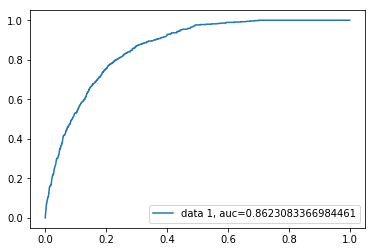

In [773]:
# plot roc_curve
y_pred_proba = model.predict_proba(train_ss)[:,1]
fpr, tpr, _ = roc_curve(y,  y_pred_proba)
auc = roc_auc_score(y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [774]:
#Get Execl Sheet
pred = pd.DataFrame({'Id': test_id.astype(int), 'WnvPresent': y_pred_log[:,1]})
pred.to_csv('WNV_4.csv', header=True, index=False)